# Notebook: FFT Analysis per region
## Notebook Type: Rough Analysis
## Last Updated: 11-22-2020

In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import json
import warnings
from os import listdir
from os.path import isfile,join
import datetime
import requests
from sklearn.metrics import r2_score, accuracy_score
import catboost
import matplotlib as mpl
import sys
sys.path.append('.')
from src.utils import collect_data
from src.utils import eda
import warnings
warnings.filterwarnings('ignore')

In [2]:
import importlib
importlib.reload(collect_data)
collect_datasets = collect_data.DataCollection()
data_analysis = eda.DataAnalysis()

In [106]:
df_mobility = collect_datasets.get_mobility_data(download=True)
df_county_spending = collect_datasets.get_spend_data()
df_covid = collect_datasets.combine_covid_data()
df_weather = collect_datasets.combine_weather(df_mobility,df_covid)
df_county = collect_datasets.combined_county_data()

In [79]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
state_abbr = dict((v,k) for k,v in us_state_abbrev.items())

df = pd.read_csv('./Data/datasets/BTS_Trips/Trips_by_Distance.csv')
df = df[df['Level'] == 'County']
df['County FIPS'] = df['County FIPS'].astype(int).astype(str).str.zfill(5)
df['State_Name'] = df['State Postal Code'].apply(lambda x:state_abbr[x])
df['full_County']  = df['County Name'] + ', '+ df['State_Name']
county_dict = df.set_index('County FIPS')['full_County'].to_dict()
fips_dict = df_county.set_index('NAME_E')['fips'].to_dict()
df_mobility['full_County']  = df_mobility['fips'].apply(lambda x:county_dict[x])
df_mobility['fips'] = df_mobility['full_County'].apply(lambda x:fips_dict[x])
df_mobility

,Level,date,State Postal Code,fips,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,...,mobility_per_trip_long,mobility_per_person_short,mobility_per_person_long,pct_stay_home,trips_per_person,trips_per_person_short,trips_per_person_long,Max_Trip_Type,pct_not_home,full_County
0,County,2019-01-01,MO,29199,1155.0,3587.0,12429.0,2807.0,3642.0,1272.0,...,5.905543,20.440321,15.478701,24.356811,2.621046,2.524673,0.096373,Number of Trips 1-3,75.643189,"Scotland County, Missouri"
1,County,2019-01-01,AL,01025,9624.0,45807.0,132004.0,27097.0,35263.0,18315.0,...,5.028067,16.092475,11.973895,17.362126,2.381411,2.298714,0.082697,Number of Trips 1-3,82.637874,"Clarke County, Alabama"
2,County,2019-01-01,AL,01025,44415.0,172941.0,534520.0,120752.0,142931.0,68235.0,...,4.167664,16.375223,10.249084,20.434219,2.459191,2.401075,0.058117,Number of Trips 1-3,79.565781,"Clarke County, Alabama"
3,County,2019-01-01,AL,01025,4782.0,20023.0,67658.0,15524.0,16677.0,10550.0,...,4.893361,16.987543,13.347107,19.278371,2.727595,2.601371,0.126225,Number of Trips 1-3,80.721629,"Clarke County, Alabama"
4,County,2019-01-01,AL,01025,3861.0,18471.0,54827.0,11602.0,15874.0,7590.0,...,5.332227,17.837028,13.091080,17.289092,2.455087,2.369291,0.085796,Number of Trips 1-3,82.710908,"Clarke County, Alabama"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191814,County,2020-12-05,AL,01105,1207.0,7933.0,40053.0,7904.0,8595.0,8207.0,...,3.533443,36.826039,15.484136,13.205689,4.382166,4.219037,0.163129,Number of Trips 1-3,86.794311,"Perry County, Alabama"
2191815,County,2020-12-05,AL,01107,2775.0,17163.0,60989.0,9050.0,13207.0,9870.0,...,5.138632,30.234928,15.718728,13.918146,3.058933,2.904454,0.154479,Number of Trips 1-3,86.081854,"Pickens County, Alabama"
2191816,County,2020-12-05,AL,01109,6434.0,26904.0,110186.0,22626.0,27240.0,14927.0,...,7.462836,21.933934,24.665547,19.299298,3.305117,3.073850,0.231268,Number of Trips 1-3,80.700702,"Pike County, Alabama"
2191817,County,2020-12-05,AL,01111,3600.0,19125.0,72545.0,14220.0,13276.0,8573.0,...,6.779240,31.587415,21.641364,15.841584,3.192299,3.006953,0.185347,Number of Trips <1,84.158416,"Randolph County, Alabama"


In [80]:
def get_df_2019(df_weather, df_mob,df_covid,df_demographics,year=2019):
    df_mob = df_mob.dropna()
    thr_date = '2020-01-01'
    covid_date = '2020-03-15'
    if year==2020:
        df_mob_prep = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='inner')
        df_mob_prep = df_mob_prep[df_mob_prep.date >=thr_date]
    elif year =='covid':
        df_mob_prep = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='inner')
        df_mob_prep = df_mob_prep[df_mob_prep.date >=covid_date]
    elif year==2019:
        df_mob_prep = df_mob[(df_mob.date < thr_date)]
        
    df_mob_weather = pd.merge(left = df_mob_prep, right = df_weather, on =['date', 'fips'])

    return df_mob_prep

In [81]:
df_2019 = get_df_2019(df_weather, df_mobility, df_covid, df_demographics=df_county,year=2019)
df_2019_fil = df_2019[df_2019['State Postal Code'] != 'AK']
df_covid_mob = get_df_2019(df_weather, df_mobility, df_covid, df_demographics=df_county,year = 'covid')
df_covid_fil = df_covid_mob[df_covid_mob['State Postal Code'] != 'AK']


In [82]:
df_2019

,Level,date,State Postal Code,fips,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,...,mobility_per_trip_long,mobility_per_person_short,mobility_per_person_long,pct_stay_home,trips_per_person,trips_per_person_short,trips_per_person_long,Max_Trip_Type,pct_not_home,full_County
0,County,2019-01-01,MO,29199,1155.0,3587.0,12429.0,2807.0,3642.0,1272.0,...,5.905543,20.440321,15.478701,24.356811,2.621046,2.524673,0.096373,Number of Trips 1-3,75.643189,"Scotland County, Missouri"
1,County,2019-01-01,AL,01025,9624.0,45807.0,132004.0,27097.0,35263.0,18315.0,...,5.028067,16.092475,11.973895,17.362126,2.381411,2.298714,0.082697,Number of Trips 1-3,82.637874,"Clarke County, Alabama"
2,County,2019-01-01,AL,01025,44415.0,172941.0,534520.0,120752.0,142931.0,68235.0,...,4.167664,16.375223,10.249084,20.434219,2.459191,2.401075,0.058117,Number of Trips 1-3,79.565781,"Clarke County, Alabama"
3,County,2019-01-01,AL,01025,4782.0,20023.0,67658.0,15524.0,16677.0,10550.0,...,4.893361,16.987543,13.347107,19.278371,2.727595,2.601371,0.126225,Number of Trips 1-3,80.721629,"Clarke County, Alabama"
4,County,2019-01-01,AL,01025,3861.0,18471.0,54827.0,11602.0,15874.0,7590.0,...,5.332227,17.837028,13.091080,17.289092,2.455087,2.369291,0.085796,Number of Trips 1-3,82.710908,"Clarke County, Alabama"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126283,County,2019-12-31,WY,56045,7426.0,38573.0,303648.0,71182.0,88068.0,52121.0,...,5.735589,31.150536,37.861693,16.143829,6.601187,6.253223,0.347964,Number of Trips 1-3,83.856171,"Weston County, Wyoming"
1126284,County,2019-12-31,WY,56045,3277.0,11648.0,75866.0,27478.0,24709.0,5795.0,...,6.552013,26.293434,33.304858,21.956449,5.083149,4.814807,0.268342,Number of Trips <1,78.043551,"Weston County, Wyoming"
1126285,County,2019-12-31,WY,56045,2199.0,11399.0,90727.0,19692.0,25083.0,15755.0,...,9.833622,36.908884,65.610752,16.171496,6.672084,5.889984,0.782100,Number of Trips 1-3,83.828504,"Weston County, Wyoming"
1126286,County,2019-12-31,WY,56045,1484.0,5943.0,37025.0,11275.0,4185.0,1569.0,...,8.214720,68.918271,40.951932,19.981150,4.985189,4.586509,0.398680,Number of Trips <1,80.018850,"Weston County, Wyoming"


In [90]:
df_county[df_county.NAME_E.str.contains('Middle')]['fips'].unique()

array(['09007', '25017', '34023', '51119'], dtype=object)

In [86]:
'Middlesex County, Connecticut' == 'Middlesex County, Connecticut'

True

In [97]:
df_mobility[df_mobility['full_County'].str.contains('New York')]['fips'].unique()

array(['36099', '36123', '36001', '36003', '36005', '36007', '36009',
       '36011', '36013', '36015', '36017', '36019', '36021', '36023',
       '36025', '36027', '36029', '36031', '36033', '36035', '36037',
       '36039', '36041', '36043', '36045', '36047', '36049', '36051',
       '36053', '36055', '36057', '36059', '36061', '36063', '36065',
       '36067', '36069', '36071', '36073', '36075', '36077', '36079',
       '36081', '36083', '36085', '36087', '36089', '36091', '36093',
       '36095', '36097', '36101', '36103', '36105', '36107', '36109',
       '36111', '36113', '36115', '36117', '36119', '36121'], dtype=object)

In [96]:
df_2019[df_2019['full_County'].str.contains('New York')]['full_County'].unique()

array(['Seneca County, New York', 'Yates County, New York'], dtype=object)

In [98]:
df_mobility[df_mobility.fips =='36061']

,Level,date,State Postal Code,fips,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,...,mobility_per_trip_long,mobility_per_person_short,mobility_per_person_long,pct_stay_home,trips_per_person,trips_per_person_short,trips_per_person_long,Max_Trip_Type,pct_not_home,full_County
2171715,County,2020-11-29,NY,36061,907007.0,721694.0,3378041.0,1264184.0,859806.0,355369.0,...,3.522759,9.283724,7.306452,55.688982,2.074071,2.028964,0.045107,Number of Trips <1,44.311018,"New York County, New York"
2174806,County,2020-11-30,NY,36061,891679.0,737022.0,3533434.0,1297090.0,904005.0,387872.0,...,2.993115,9.775311,6.493503,54.747863,2.169480,2.130688,0.038792,Number of Trips <1,45.252137,"New York County, New York"
2177973,County,2020-12-01,NY,36061,857035.0,771666.0,3743281.0,1380144.0,952294.0,419176.0,...,2.655358,10.464012,6.102870,52.620770,2.298323,2.261224,0.037100,Number of Trips <1,47.379230,"New York County, New York"
2181127,County,2020-12-02,NY,36061,853612.0,775089.0,3753610.0,1375646.0,974203.0,415584.0,...,2.666839,10.297251,6.146171,52.410602,2.304665,2.267870,0.036795,Number of Trips <1,47.589398,"New York County, New York"
2184589,County,2020-12-03,NY,36061,844977.0,783724.0,3981918.0,1568008.0,944103.0,436781.0,...,2.685841,10.720284,6.566460,51.880425,2.444843,2.405450,0.039393,Number of Trips <1,48.119575,"New York County, New York"
2187393,County,2020-12-04,NY,36061,841247.0,787454.0,3899635.0,1457717.0,961633.0,462493.0,...,2.741737,10.631056,6.564603,51.651408,2.394322,2.352393,0.041929,Number of Trips <1,48.348592,"New York County, New York"
2190493,County,2020-12-05,NY,36061,872093.0,756608.0,3711829.0,1399605.0,904735.0,427766.0,...,2.808710,10.062882,6.401083,53.545310,2.279012,2.240164,0.038848,Number of Trips <1,46.454690,"New York County, New York"


In [105]:
df[df['County Name'].str.contains('New York')]

,Level,Date,State FIPS,State Postal Code,County FIPS,County Name,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,...,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,State_Name,full_County
926,County,2019-01-01,NaN,NY,00360,New York County,749761.0,873962.0,4100437.0,1719701.0,...,422930.0,508045.0,346964.0,90906.0,49855.0,23921.0,4399.0,14803.0,New York,"New York County, New York"
5638,County,2019-01-02,NaN,NY,00360,New York County,610531.0,1013192.0,4941594.0,1977881.0,...,545181.0,660037.0,415380.0,101724.0,42639.0,20922.0,4770.0,14413.0,New York,"New York County, New York"
7208,County,2019-01-03,NaN,NY,00360,New York County,623592.0,1000131.0,4903422.0,1987974.0,...,551272.0,641239.0,398134.0,86203.0,41241.0,19167.0,4551.0,15469.0,New York,"New York County, New York"
11921,County,2019-01-04,NaN,NY,00360,New York County,611224.0,1012499.0,4933926.0,1956709.0,...,561908.0,662838.0,402614.0,89740.0,45928.0,20500.0,4570.0,13544.0,New York,"New York County, New York"
13491,County,2019-01-05,NaN,NY,00360,New York County,636568.0,987155.0,4852846.0,1893935.0,...,540608.0,631854.0,399164.0,95441.0,51509.0,21073.0,4322.0,12277.0,New York,"New York County, New York"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237538,County,2020-12-01,36.0,NY,36061,New York County,857035.0,771666.0,3743281.0,1380144.0,...,419176.0,509145.0,343794.0,78304.0,38598.0,14538.0,2574.0,4714.0,New York,"New York County, New York"
2240697,County,2020-12-02,36.0,NY,36061,New York County,853612.0,775089.0,3753610.0,1375646.0,...,415584.0,526542.0,327025.0,74682.0,38558.0,13411.0,3194.0,4765.0,New York,"New York County, New York"
2244162,County,2020-12-03,36.0,NY,36061,New York County,844977.0,783724.0,3981918.0,1568008.0,...,436781.0,546605.0,344678.0,77584.0,41822.0,14038.0,2994.0,5305.0,New York,"New York County, New York"
2246975,County,2020-12-04,36.0,NY,36061,New York County,841247.0,787454.0,3899635.0,1457717.0,...,462493.0,531957.0,341745.0,75800.0,46186.0,14574.0,2587.0,4943.0,New York,"New York County, New York"


In [101]:
df_mobility[df_mobility['full_County'].str.contains('New York')]['full_County'].unique()

array(['Seneca County, New York', 'Yates County, New York',
       'Albany County, New York', 'Allegany County, New York',
       'Bronx County, New York', 'Broome County, New York',
       'Cattaraugus County, New York', 'Cayuga County, New York',
       'Chautauqua County, New York', 'Chemung County, New York',
       'Chenango County, New York', 'Clinton County, New York',
       'Columbia County, New York', 'Cortland County, New York',
       'Delaware County, New York', 'Dutchess County, New York',
       'Erie County, New York', 'Essex County, New York',
       'Franklin County, New York', 'Fulton County, New York',
       'Genesee County, New York', 'Greene County, New York',
       'Hamilton County, New York', 'Herkimer County, New York',
       'Jefferson County, New York', 'Kings County, New York',
       'Lewis County, New York', 'Livingston County, New York',
       'Madison County, New York', 'Monroe County, New York',
       'Montgomery County, New York', 'Nassau County, 

In [100]:
df_2019[df_2019['full_County'].str.contains('New York')]['full_County'].unique()

array(['Seneca County, New York', 'Yates County, New York'], dtype=object)

In [71]:
df_2019[df_2019.fips =='36061']

,Level,date,State Postal Code,fips,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,...,mobility_per_trip_long,mobility_per_person_short,mobility_per_person_long,pct_stay_home,trips_per_person,trips_per_person_short,trips_per_person_long,Max_Trip_Type,pct_not_home,full_County


In [68]:
df_county_1

,Level,date,State Postal Code,fips,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,...,mobility_per_trip_long,mobility_per_person_short,mobility_per_person_long,pct_stay_home,trips_per_person,trips_per_person_short,trips_per_person_long,Max_Trip_Type,pct_not_home,full_County


In [92]:
df_2019[df_2019.fips =='36061']

,Level,date,State Postal Code,fips,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,...,mobility_per_trip_long,mobility_per_person_short,mobility_per_person_long,pct_stay_home,trips_per_person,trips_per_person_short,trips_per_person_long,Max_Trip_Type,pct_not_home,full_County


<Figure size 1080x720 with 0 Axes>

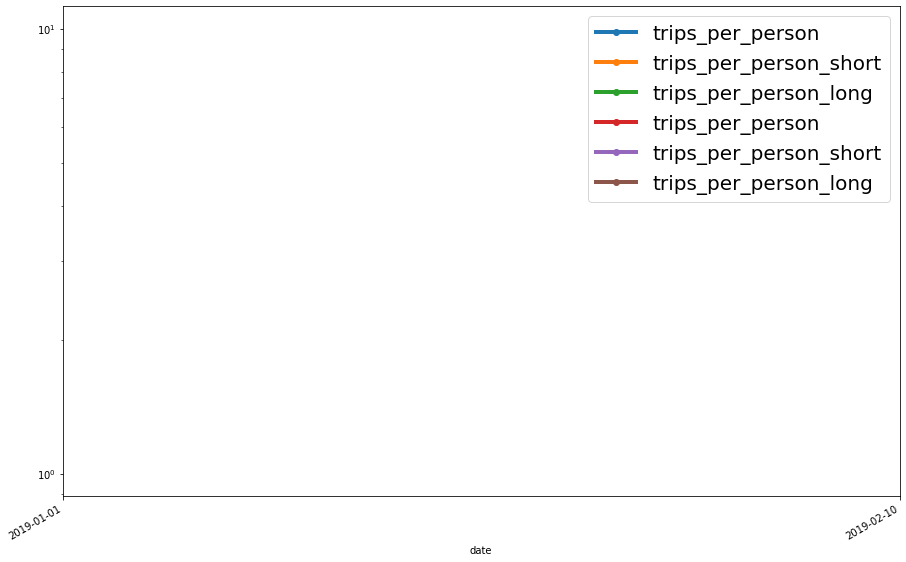

In [91]:
col = 'Number of Trips 1-3'
plt.figure(figsize=(15,10))
df_county_1 = df_2019[df_2019.fips =='25017']
df_county_2 = df_2019[df_2019.fips =='36061']
trip_cols = [col for col in df_county_1.columns if 'trips_per' in col]
for c in trip_cols:
    df_county_1[c] = df_county_1[c]#/df_county_1['Population']
    df_county_2[c] = df_county_2[c]#/df_county_2['Population']
ax = df_county_1.set_index('date')[trip_cols[:]].plot.line(figsize=(15,10),lw=4,style='-o')
df_county_2.set_index('date')[trip_cols[:]].plot.line(ax=ax,lw=4,style='-o')
plt.legend(fontsize=20)
plt.xlim('2019-01-01','2019-02-10')
plt.xticks()
plt.yscale('log')
plt.show()

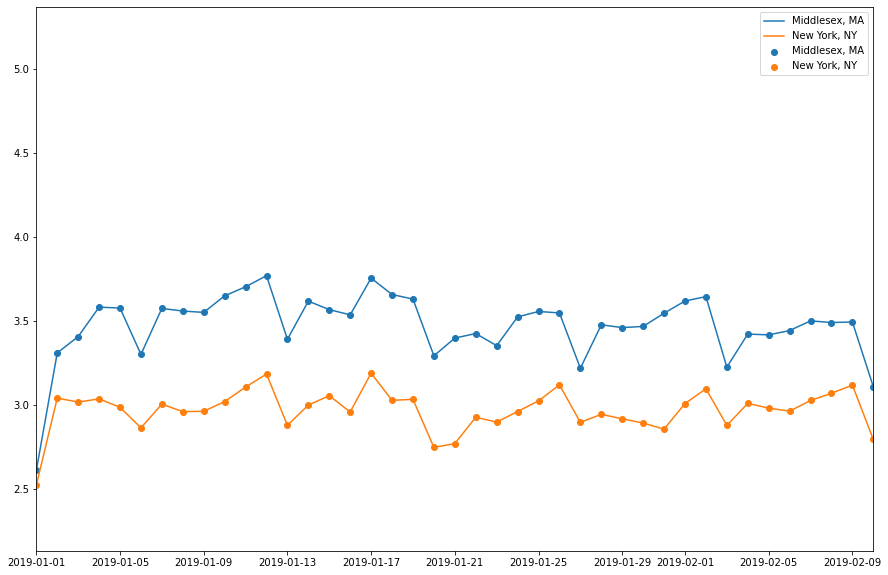

In [44]:
col = 'trips_per_person'
plt.figure(figsize=(15,10))
df_county_1 = df_2019[df_2019.fips =='48201']
df_county_2 = df_2019[df_2019.fips =='36061']
trip_cols = [col for col in df_county_1.columns if 'trips_per' in col]
x1 = df_county_1.set_index('date')[col]
x2 = df_county_2.set_index('date')[col]
# x1 = (x1-x1.mean())/x1.mean()
# x2 = (x2-x2.mean())/x2.mean()
plt.plot(x1,label = 'Middlesex, MA')
plt.scatter(x1.index,x1.values,label = 'Middlesex, MA')
plt.plot(x2, label = 'New York, NY')
plt.scatter(x2.index,x2.values, label = 'New York, NY')

plt.legend()
plt.xlim('2019-01-01','2019-02-10')
plt.xticks()
plt.show()

In [61]:
def get_fft_mean(x,high_pass_cutoff=5):
    
    x =( x - x.mean())/x.mean()
    fourier = np.fft.fft(x)
    power = np.abs(fourier)
    n = x.size
    timestep = 1/365
    freq = np.fft.fftfreq(n, d=timestep)
    mask = freq >= 0
    power[np.abs(freq) < high_pass_cutoff] = 0
#     power[np.abs(freq) > low_pass_cutoff] = 0
    return freq[mask],power[mask]

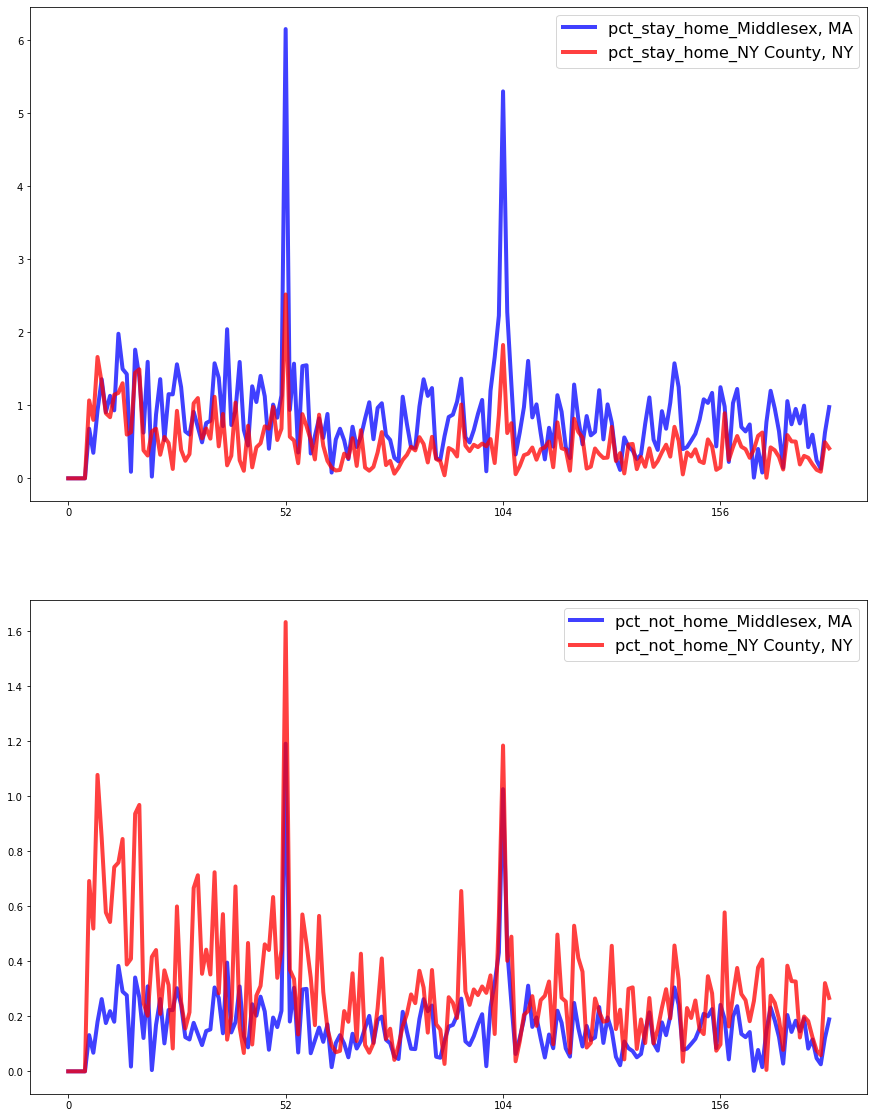

In [70]:
trip_cols = [col for col in df_county_1.columns if 'home' in col]

fig,ax = plt.subplots(nrows =len(trip_cols), ncols=1,figsize=(15,20))
df_county_1 = df_2019[df_2019.fips =='48201']
df_county_2 = df_2019[df_2019.fips =='36061']
for axes,col in zip(ax.flatten(),trip_cols):
#     df_county_1[col] = df_county_1[col]/df_county_1['Population']
#     df_county_2[col] = df_county_2[col]/df_county_2['Population']
    x1 = df_county_1.set_index('date')[col]
    x2 = df_county_2.set_index('date')[col]
    freq_x1,fft_x1 = get_fft_mean(x1)
    freq_x2,fft_x2 = get_fft_mean(x2)

#     plt.scatter(freq_x1,fft_x1,alpha=0.5,s=20)
    axes.plot(freq_x1,fft_x1,label=col+ '_Middlesex, MA',alpha=0.75,lw=4,linestyle='-',color='blue')
    axes.plot(freq_x2,fft_x2,label=col+ '_NY County, NY',alpha=0.75,lw=4,linestyle='-',color='red')
#     input('Press Enter to continue')
    axes.legend(fontsize=16)
    axes.xaxis.set_major_locator(plt.MultipleLocator(52))






In [66]:
def get_xn(Xs,n):
    '''
    calculate the Fourier coefficient X_n of 
    Discrete Fourier Transform (DFT)
    '''
    L  = len(Xs)
    ks = np.arange(0,L,1)
    xn = np.sum(Xs*np.exp((1j*2*np.pi*ks*n)/L))/L
    return(xn)

def get_xns(ts):
    '''
    Compute Fourier coefficients only up to the Nyquest Limit Xn, n=1,...,L/2
    and multiply the absolute value of the Fourier coefficients by 2, 
    to account for the symetry of the Fourier coefficients above the Nyquest Limit. 
    '''
    mag = []
    L = len(ts)
    for n in range(int(L/2)): # Nyquest Limit
        mag.append(np.abs(get_xn(ts,n))*2)
    return(mag)
def create_spectrogram(ts,NFFT,noverlap = None):
    '''
          ts: original time series
        NFFT: The number of data points used in each block for the DFT.
          Fs: the number of points sampled per second, so called sample_rate
    noverlap: The number of points of overlap between blocks. The default value is 128. 
    '''
    if noverlap is None:
        noverlap = NFFT/2
    noverlap = int(noverlap)
    starts  = np.arange(0,len(ts),NFFT-noverlap,dtype=int)
    # remove any window with less than NFFT sample size
    starts  = starts[starts + NFFT < len(ts)]
    xns = []
    for start in starts:
        # short term discrete fourier transform
        ts_window = get_xns(ts[start:start + NFFT]) 
        xns.append(ts_window)
    specX = np.array(xns).T
    # rescale the absolute value of the spectrogram as rescaling is standard
    spec = 10*np.log10(specX)
    assert spec.shape[1] == len(starts) 
    return(starts,spec)

L = 256
noverlap = 84
starts, spec = create_spectrogram(x1,L,noverlap = noverlap )

<AxesSubplot:xlabel='weekday'>

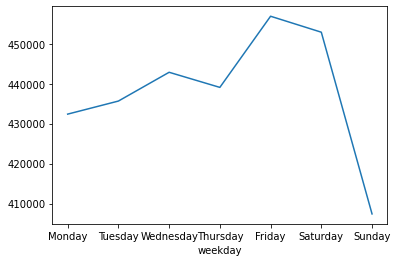

In [76]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
# week_df = df_data.groupby(df_data['arrival_date'].dt.weekday_name).mean()
df_2019.groupby('weekday')['Number of Trips'].mean().reindex(days).plot()

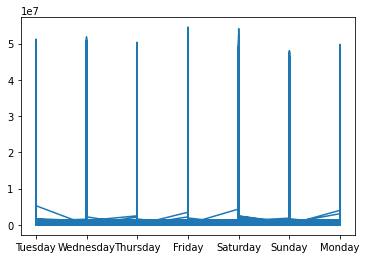

In [74]:
plt.plot(df_mobility.weekday.values,df_mobility['Number of Trips'].values )

<AxesSubplot:xlabel='weekday'>

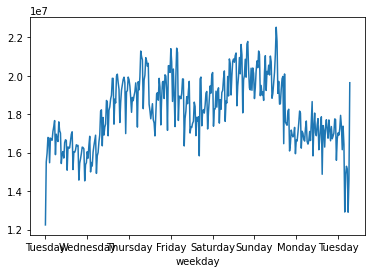

In [68]:
df_county_1.set_index('weekday')['Number of Trips'].plot()

In [67]:
def plot_spectrogram(spec,ks,sample_rate, L, starts, mappable = None):
    plt.figure(figsize=(20,8))
    plt_spec = plt.imshow(spec,origin='lower')

    ## create ylim
    Nyticks = 10
    ks      = np.linspace(0,spec.shape[0],Nyticks)
    ksHz    = get_Hz_scale_vec(ks,sample_rate,len(ts))
    plt.yticks(ks,ksHz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    Nxticks = 10
    ts_spec = np.linspace(0,spec.shape[1],Nxticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0,total_ts_sec*starts[-1]/len(ts),Nxticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title("Spectrogram L={} Spectrogram.shape={}".format(L,spec.shape))
    plt.colorbar(mappable,use_gridspec=True)
    plt.show()
    return(plt_spec)
plot_spectrogram(spec,ks,sample_rate,L, starts)

NameError: name 'ks' is not defined

ValueError: operands could not be broadcast together with shapes (256,) (183,) 

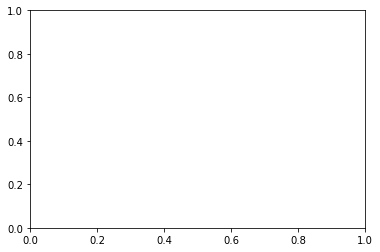

In [63]:
plt.specgram(x1, Fs=freq_x1)

In [ ]:

# Start Value of the sample
start   = 1

# Stop Value of the sample
stop    = samplingFrequency+1

for frequency in frequencies:

    sub1 = np.arange(start, stop, 1)

 

    # Signal - Sine wave with varying frequency + Noise

    sub2 = np.sin(2*np.pi*sub1*frequency*1/samplingFrequency)+np.random.randn(len(sub1))

  

    s1      = np.append(s1, sub1)

    s2      = np.append(s2, sub2)

   

    start   = stop+1

    stop    = start+samplingFrequency

 

# Plot the signal

plot.subplot(211)

plot.plot(s1,s2)

plot.xlabel('Sample')

plot.ylabel('Amplitude')

 

 

# Plot the spectrogram

plot.subplot(212)

powerSpectrum, freqenciesFound, time, imageAxis = plot.specgram(s2, Fs=samplingFrequency)

plot.xlabel('Time')

plot.ylabel('Frequency')

 

plot.show()   

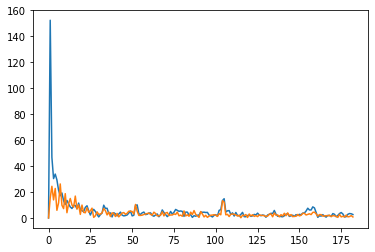

In [115]:
from scipy import fftpack
import scipy
df_county_1 = df_2019[df_2019.fips =='25017']
df_county_2 = df_2019[df_2019.fips =='36061']
x1 = df_county_1.set_index('date')[col].values
x2 = df_county_2.set_index('date')[col].values
# x1 = (x1-x1.mean())/x1.mean()
# x2 = (x2-x2.mean())/x2.mean()
# df_county.set_index('date')['Number of Trips'].plot()
freq_x1,fft_x1 = get_fft_mean(x1)
freq_x2,fft_x2 = get_fft_mean(x2)

plt.plot(freq_x1,fft_x1)
plt.plot(freq_x2,fft_x2)
# plt.yscale('log')
# plt.ylim(1e15,1e19)

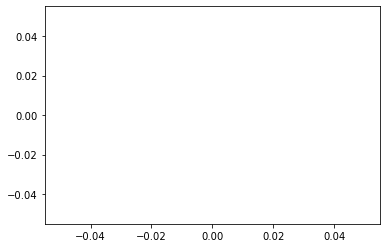

In [111]:
plt.plot(freq_x2,fft_x2)

In [35]:
max(fft_x2[freq_x2>2])

8.369787993221093

In [44]:
365/(freq_x2[freq_x2>5][np.argmax(fft_x2[freq_x2>5])])

7.019230769230769

In [42]:
365/(freq_x1[freq_x1>5][np.argmax(fft_x1[freq_x1>5])])

60.833333333333336

In [45]:
freq_x1[np.argmax(fft_x1[freq_x1>5])]

0.0